# General information

In Santander Customer Transaction Prediction competition we have a binary classification task. Train and test data have 200k samples each and we have 200 anonimyzed numerical columns. It would be interesting to try good models without overfitting and knowing the meaning of the features.
In fact this competition seems to be similar to another current competition: don't overfit II, so I'll use a lot of ideas from my [kernel](https://www.kaggle.com/artgor/how-to-not-overfit).

In this kernel I'll write the following things:

* EDA on the features and trying to get some insights;
* Using permutation importance to select most impactful features;
* Comparing various models: linear models, tree based models and others;
* Trying various approaches to feature selection including taking top features from eli5;
* Hyperparameter optimization for models;
* Feature generation;
* Other things;

![](https://i.imgur.com/e5vPHpJ.png)

*Work still in progress*

In [1]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
import json
import ast
import time
from sklearn import linear_model
import eli5
from eli5.sklearn import PermutationImportance
import shap
from tqdm import tqdm_notebook
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train.shape, test.shape

((200000, 202), (200000, 201))

## Data exploration

In [3]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697

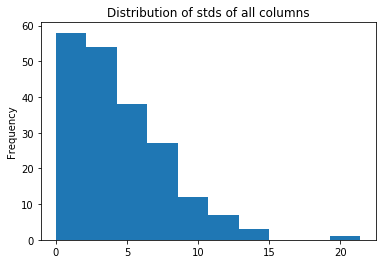

In [4]:
train[train.columns[2:]].std().plot('hist');
plt.title('Distribution of stds of all columns');

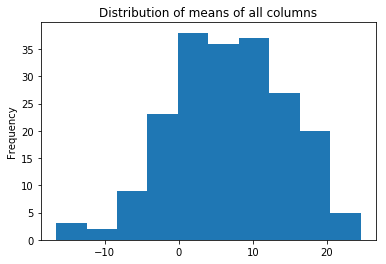

In [5]:
train[train.columns[2:]].mean().plot('hist');
plt.title('Distribution of means of all columns');

In [6]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697

In [7]:
# we have no missing values
train.isnull().any().any()

False

Distributions of first 28 columns


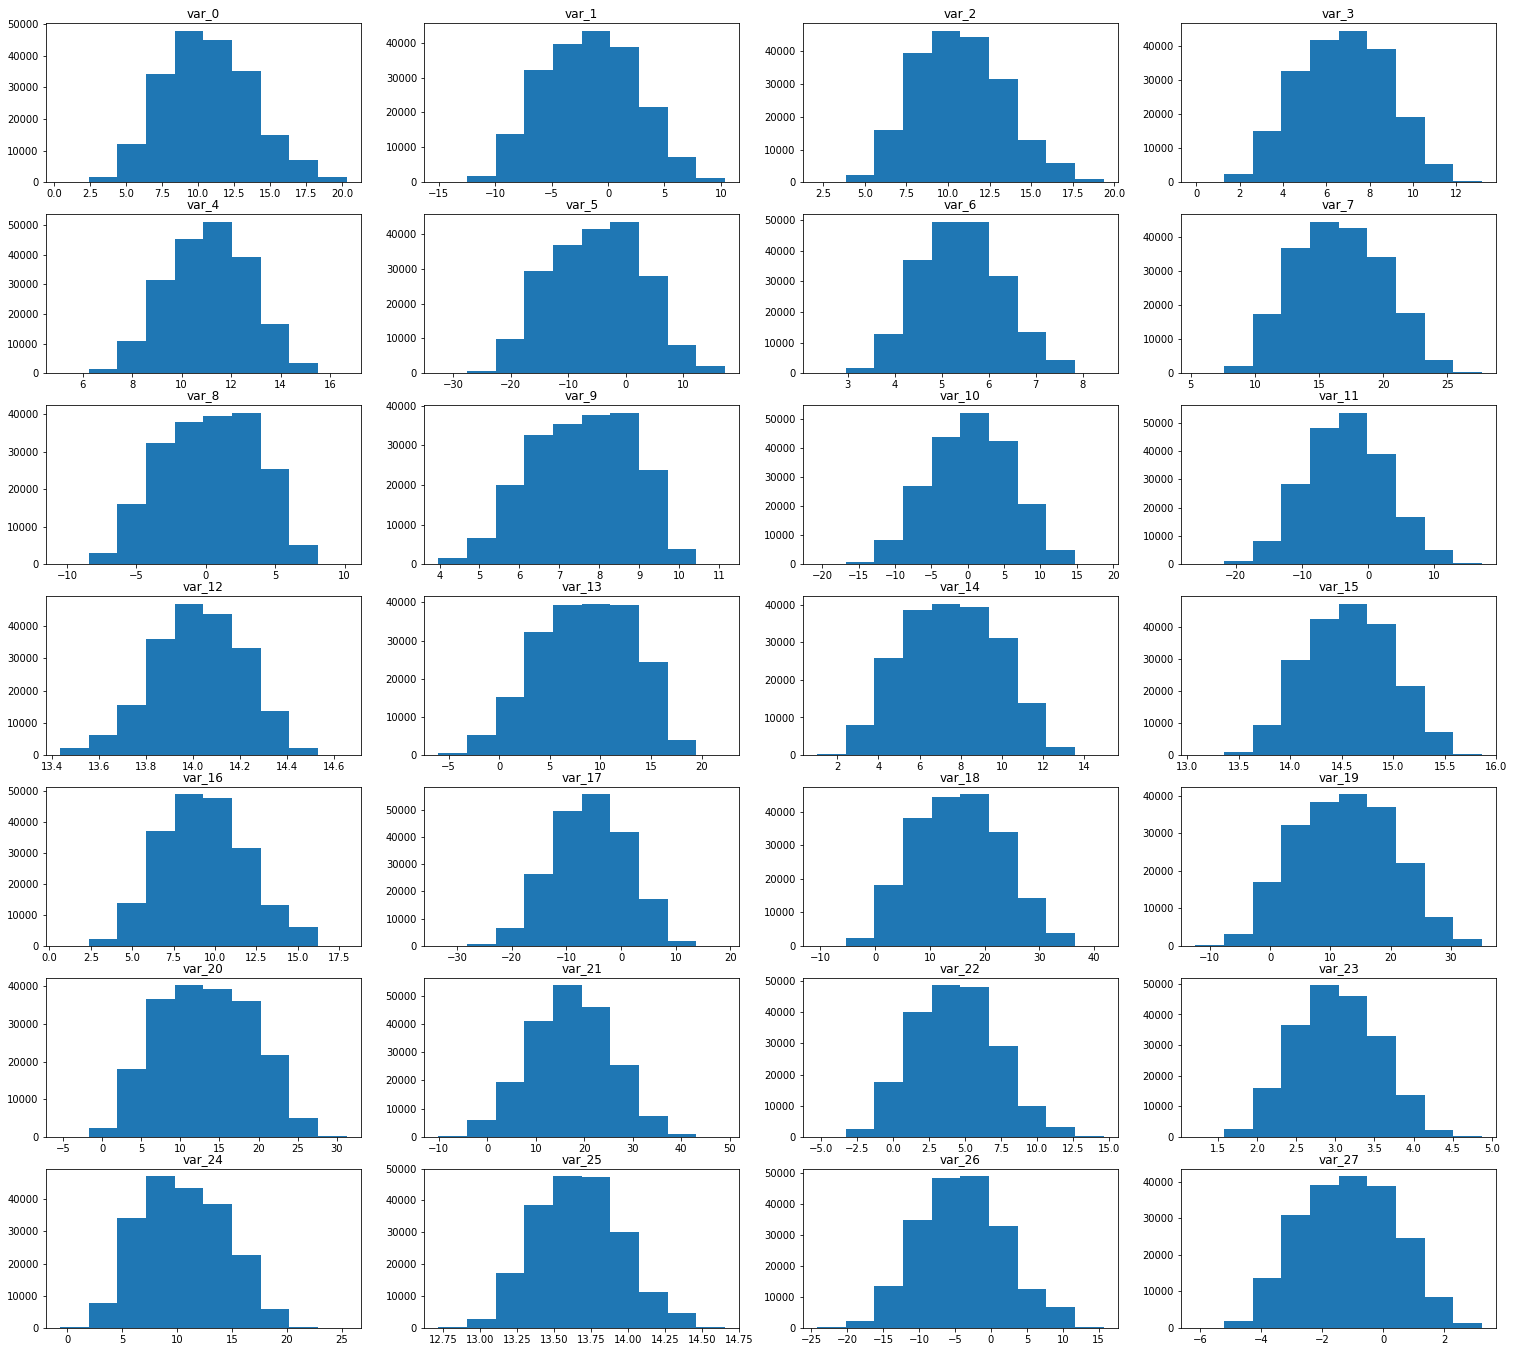

In [8]:
print('Distributions of first 28 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(train[col])
    plt.title(col)

In [9]:
train['target'].value_counts(normalize=True)

0    0.89951
1    0.10049
Name: target, dtype: float64

From this overview we can see the following things:
* target is binary and has disbalance: 10% of samples belong to 1 class;
* values in columns are more or less similar;
* columns have high std (up to 20)
* columns have a high range of means;

Let's have a look at correlations now!

In [10]:
corrs = train.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(30)

,level_0,level_1,0
40170,target,var_80,0.057609
40171,var_80,target,0.057609
40172,var_166,target,0.057773
40173,target,var_166,0.057773
40174,var_99,target,0.058367
40175,target,var_99,0.058367
40176,target,var_21,0.058483
40177,var_21,target,0.058483
40178,target,var_22,0.060558
40179,var_22,target,0.060558


In [11]:
corrs.head()

,level_0,level_1,0
0,var_191,var_75,2.703975e-08
1,var_75,var_191,2.703975e-08
2,var_173,var_6,5.942735e-08
3,var_6,var_173,5.942735e-08
4,var_126,var_109,1.313947e-07


We can see that all features have a low correlation with target. So we have no highly correlated features which we could drop, on the other hand we could drop some columns with have little correlation with the target.

## Basic modelling

In [12]:
X = train.drop(['ID_code', 'target'], axis=1)
y = train['target']
X_test = test.drop(['ID_code'], axis=1)
n_fold = 4
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [13]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [14]:
# %%time
# model = linear_model.LogisticRegression(class_weight='balanced', penalty='l2', C=0.1)
# oof_lr, prediction_lr, scores = train_model(X, X_test, y, params=None, folds=folds, model_type='sklearn', model=model)

In [15]:
params = {'num_leaves': 128,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}
# oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [16]:
# sub = pd.read_csv('../input/sample_submission.csv')
# sub['target'] = prediction_lgb
# sub.to_csv('lgb.csv', index=False)

## ELI5

In [17]:
model = lgb.LGBMClassifier(**params, n_estimators = 20000, n_jobs = -1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.98645	valid_1's auc: 0.884121
[2000]	training's auc: 0.998165	valid_1's auc: 0.890728
[3000]	training's auc: 0.999894	valid_1's auc: 0.891196
Early stopping, best iteration is:
[3373]	training's auc: 0.999969	valid_1's auc: 0.891344


LGBMClassifier(bagging_freq=5, bagging_seed=11, boosting='gbdt',
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.8201, importance_type='split',
        learning_rate=0.0123, max_depth=16, metric='auc',
        min_child_samples=20, min_child_weight=19.428902804238373,
        min_data_in_leaf=42, min_gain_to_split=0.01077313523861969,
        min_split_gain=0.0, n_estimators=20000, n_jobs=-1, num_leaves=128,
        num_threads=4, objective='binary', random_state=42,
        reg_alpha=1.728910519108444, reg_lambda=4.9847051755586085,
        silent=True, subsample=0.81, subsample_for_bin=200000,
        subsample_freq=0, verbosity=-1)

In [18]:
eli5.show_weights(model, targets=[0, 1], feature_names=list(X_train.columns), top=40, feature_filter=lambda x: x != '<BIAS>')

Weight,Feature
0.0184,var_81
0.0155,var_139
0.0148,var_12
0.0133,var_53
0.0130,var_174
0.0128,var_6
0.0127,var_110
0.0124,var_22
0.0123,var_146
0.0123,var_26


ELI5 didn't help up to eliminate features, but let's at least try to take top-100 and see how it helps.

In [19]:
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:100]
X1 = X[top_features]
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.977991	valid_1's auc: 0.87813
Early stopping, best iteration is:
[1649]	training's auc: 0.990685	valid_1's auc: 0.87999


LGBMClassifier(bagging_freq=5, bagging_seed=11, boosting='gbdt',
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.8201, importance_type='split',
        learning_rate=0.0123, max_depth=16, metric='auc',
        min_child_samples=20, min_child_weight=19.428902804238373,
        min_data_in_leaf=42, min_gain_to_split=0.01077313523861969,
        min_split_gain=0.0, n_estimators=20000, n_jobs=-1, num_leaves=128,
        num_threads=4, objective='binary', random_state=42,
        reg_alpha=1.728910519108444, reg_lambda=4.9847051755586085,
        silent=True, subsample=0.81, subsample_for_bin=200000,
        subsample_freq=0, verbosity=-1)

In [20]:
def calculate_metrics(model, X_train: pd.DataFrame() = None, y_train: pd.DataFrame() = None, X_valid: pd.DataFrame() = None,
                      y_valid: pd.DataFrame() = None, columns: list = []) -> pd.DataFrame():
    columns = columns if len(columns) > 0 else list(X_train.columns)
    train_pred = model.predict_proba(X_train[columns])
    valid_pred = model.predict_proba(X_valid[columns])
    f1 = 0
    best_t = 0
    for t in np.arange(0.1, 1, 0.05):
        valid_pr = (valid_pred[:, 1] > t).astype(int)
        valid_f1 = metrics.f1_score(y_valid, valid_pr)
        if valid_f1 > f1:
            f1 = valid_f1
            best_t = t

    t = best_t
    train_pr = (train_pred[:, 1] > t).astype(int)
    valid_pr = (valid_pred[:, 1] > t).astype(int)
    train_f1 = metrics.f1_score(y_train, train_pr)
    valid_f1 = metrics.f1_score(y_valid, valid_pr)
    score_df = []
    print(f'Best threshold: {t:.2f}. Train f1: {train_f1:.4f}. Valid f1: {valid_f1:.4f}.')
    score_df.append(['F1', np.round(train_f1, 4), np.round(valid_f1, 4)])
    train_r = metrics.recall_score(y_train, train_pr)
    valid_r = metrics.recall_score(y_valid, valid_pr)

    score_df.append(['Recall', np.round(train_r, 4), np.round(valid_r, 4)])
    train_p = metrics.precision_score(y_train, train_pr)
    valid_p = metrics.precision_score(y_valid, valid_pr)

    score_df.append(['Precision', np.round(train_p, 4), np.round(valid_p, 4)])
    train_roc = metrics.roc_auc_score(y_train, train_pred[:, 1])
    valid_roc = metrics.roc_auc_score(y_valid, valid_pred[:, 1])

    score_df.append(['ROCAUC', np.round(train_roc, 4), np.round(valid_roc, 4)])
    train_apc = metrics.average_precision_score(y_train, train_pred[:, 1])
    valid_apc = metrics.average_precision_score(y_valid, valid_pred[:, 1])

    score_df.append(['APC', np.round(train_apc, 4), np.round(valid_apc, 4)])
    print(metrics.confusion_matrix(y_valid, valid_pr))
    score_df = pd.DataFrame(score_df, columns=['Metric', 'Train', 'Valid'])
    print(score_df)

    return score_df, t

In [21]:
_ = calculate_metrics(model, X_train, y_train, X_valid, y_valid)

Best threshold: 0.20. Train f1: 0.8417. Valid f1: 0.5376.
[[33513  2467]
 [ 1635  2385]]
      Metric   Train   Valid
0         F1  0.8417  0.5376
1     Recall  0.9369  0.5933
2  Precision  0.7640  0.4915
3     ROCAUC  0.9907  0.8800
4        APC  0.9561  0.5637


## Feature generation

### Feature interaction

Didn't improve score

In [22]:
# X = train.drop(['ID_code', 'target'], axis=1)
# X_test = test.drop(['ID_code'], axis=1)

# columns = top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:20]
# for col1 in tqdm_notebook(columns):
#     for col2 in columns:
#         X[col1 + '_' + col2] = X[col1] * X[col2]   
#         X_test[col1 + '_' + col2] = X_test[col1] * X_test[col2]

In [23]:
# oof_lgb, prediction_lgb_inter, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [24]:
# sub = pd.read_csv('../input/sample_submission.csv')
# sub['target'] = prediction_lgb_inter
# sub.to_csv('lgb_inter.csv', index=False)

### Scaling

! **Notice** scaling severely decreases score

In [25]:
# X = train.drop(['ID_code', 'target'], axis=1)
# X_test = test.drop(['ID_code'], axis=1)
# scaler = StandardScaler()
# X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
# X_test[X_train.columns] = scaler.transform(X_test[X_train.columns])
# oof_lgb, prediction_lgb_scaled, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)
# sub = pd.read_csv('../input/sample_submission.csv')
# sub['target'] = prediction_lgb_scaled
# sub.to_csv('lgb_scaled.csv', index=False)

### Statistics

In [26]:
# X = train.drop(['ID_code', 'target'], axis=1)
# X_test = test.drop(['ID_code'], axis=1)

# X['std'] = X.std(1)
# X_test['std'] = X_test.std(1)

# X['mean'] = X.mean(1)
# X_test['mean'] = X_test.mean(1)
# oof_lgb, prediction_lgb_stats, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)
# sub = pd.read_csv('../input/sample_submission.csv')
# sub['target'] = prediction_lgb_stats
# sub.to_csv('lgb_stats.csv', index=False)

Training with these features gives the same score on LB: 0.899

### NN features

Takes several hours.

Fold 0 started at Mon Apr  1 00:24:19 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.987543	valid_1's auc: 0.88519
[2000]	training's auc: 0.998716	valid_1's auc: 0.892329
[3000]	training's auc: 0.999929	valid_1's auc: 0.893265
Early stopping, best iteration is:
[2901]	training's auc: 0.999901	valid_1's auc: 0.893319
Fold 1 started at Mon Apr  1 00:34:53 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.986894	valid_1's auc: 0.88917
[2000]	training's auc: 0.998637	valid_1's auc: 0.896328
[3000]	training's auc: 0.999945	valid_1's auc: 0.897256
Early stopping, best iteration is:
[3248]	training's auc: 0.999979	valid_1's auc: 0.897408
Fold 2 started at Mon Apr  1 00:46:37 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.987326	valid_1's auc: 0.88765
[2000]	training's auc: 0.998777	valid_1's auc: 0.895145
[3000]	training's auc: 0.999955	valid_1's auc: 0.895933

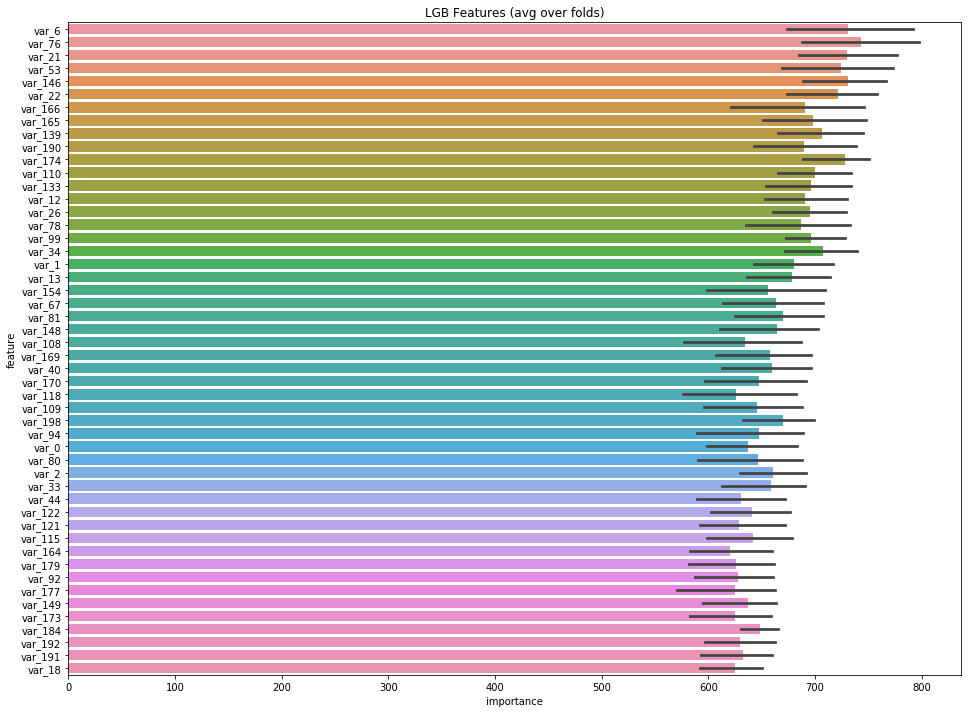

In [27]:
%%time
X = train.drop(['ID_code', 'target'], axis=1)
X_test = test.drop(['ID_code'], axis=1)
neigh = NearestNeighbors(3, n_jobs=-1)
neigh.fit(X)

dists, _ = neigh.kneighbors(X, n_neighbors=3)
mean_dist = dists.mean(axis=1)
max_dist = dists.max(axis=1)
min_dist = dists.min(axis=1)

X['mean_dist'] = mean_dist
X['max_dist'] = max_dist
X['min_dist'] = min_dist

test_dists, _ = neigh.kneighbors(X_test, n_neighbors=3)

test_mean_dist = test_dists.mean(axis=1)
test_max_dist = test_dists.max(axis=1)
test_min_dist = test_dists.min(axis=1)

X_test['mean_dist'] = test_mean_dist
X_test['max_dist'] = test_max_dist
X_test['min_dist'] = test_min_dist

oof_lgb, prediction_lgb_dist, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = prediction_lgb_dist
sub.to_csv('lgb_dist.csv', index=False)

## Blend

In [28]:
# xgb_params = {'eta': 0.05, 'max_depth': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 
#           'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'nthread': 4}
# oof_xgb, prediction_xgb, scores = train_model(X, X_test, y, params=xgb_params, folds=folds, model_type='xgb')

In [29]:
# cat_params = {'depth': 13,
#               'l2_leaf_reg': 10,
#               'bootstrap_type': 'Bernoulli',
#               #'metric_period': 500,
#               'od_type': 'Iter',
#               'od_wait': 50,
#               'random_seed': 11,
#               'allow_writing_files': False}
# oof_cat, prediction_cat, _ = train_model(X, X_test, y, params=cat_params, folds=folds, model_type='cat')

In [30]:
# sub['target'] = (prediction_lgb + prediction_xgb) / 2
# sub.to_csv('blend1.csv', index=False)
# sub['target'] = (prediction_lgb + prediction_xgb + prediction_cat) / 3
# sub.to_csv('blend2.csv', index=False)

### Rounding data

In [31]:
# oof_lgb, prediction_lgb, scores = train_model(np.round(X, 3), np.round(X_test, 3), y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)
# sub = pd.read_csv('../input/sample_submission.csv')
# sub['target'] = prediction_lgb
# sub.to_csv('lgb_rounded_3.csv', index=False)